In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from huggingface_hub import hf_hub_download


/Users/katiefrields/Documents/GitHub/climsim3/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
info_path = '/Users/katiefrields/Documents/GitHub/climsim3/grid_info/ClimSim_low-res_grid-info.nc'
grid_info = xr.open_dataset(info_path)
lon = grid_info['lon']
lat = grid_info['lat']
lon = ((lon + 180) % 360) - 180

In [31]:
grid_area = grid_info['area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid


def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted


In [ ]:
ds_sp

In [34]:
input_file_name = 'train/0001-02/E3SM-MMF.mlexpand.0001-02-01-02400.nc'
prediction_file_name = 'train/0001-02/E3SM-MMF.mlexpand.0001-02-01-06000.nc'

input_file = hf_hub_download(repo_id="LEAP/ClimSim_low-res-expanded", filename=input_file_name, repo_type="dataset")
prediction_file = hf_hub_download(repo_id="LEAP/ClimSim_low-res-expanded", filename=prediction_file_name, repo_type="dataset")

ds_sp = xr.open_dataset(input_file)
ds_nn= xr.open_dataset(prediction_file)
    
level = ds_sp['lev'].values

#ds_sp = xr.open_dataset(data_path + 'h0/1year/mmf_ref/mmf_ref.eam.h0.0003.nc')

In [ ]:
ds_sp

In [42]:
#var = 'Q'
var = 'state_q0001'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
#var_sp_re = var_sp.values
var_sp_re = np.transpose(var_sp.values, (1,0))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (1,0))
#var_nn_re = var_nn.values
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in tropics
var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level"],coords={"level": level})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level"],coords={"level": level})

bias_q= (data_nn-data_sp)

var = 'state_q0002'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (1,0))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (1,0))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in tropics

var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level"],
                                   coords={"level": level})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level"],
                                   coords={"level": level})

bias_qc= (data_nn-data_sp)



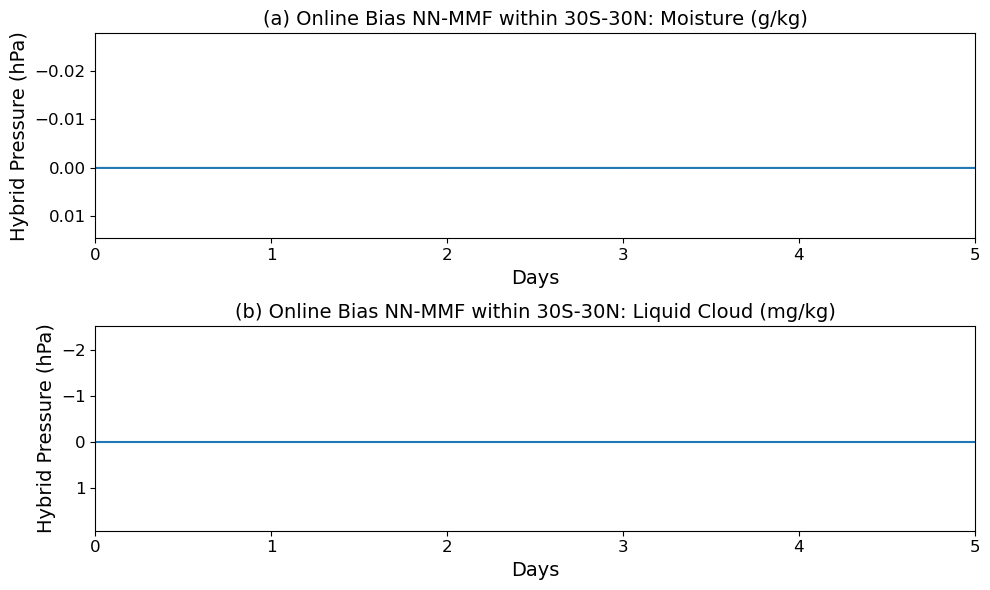

In [43]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Prepare the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax = axes[0]
(bias_q*1e3).plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim(0, 5)
ax.set_title('(a) Online Bias NN-MMF within 30S-30N: Moisture (g/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = axes[1]
(bias_qc*1e6).plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim(0, 5)
ax.set_title('(b) Online Bias NN-MMF within 30S-30N: Liquid Cloud (mg/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
# plt.savefig('/global/homes/z/zeyuanhu/notebooks/james-plots/error-growth.pdf', format='pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
plt.show()
